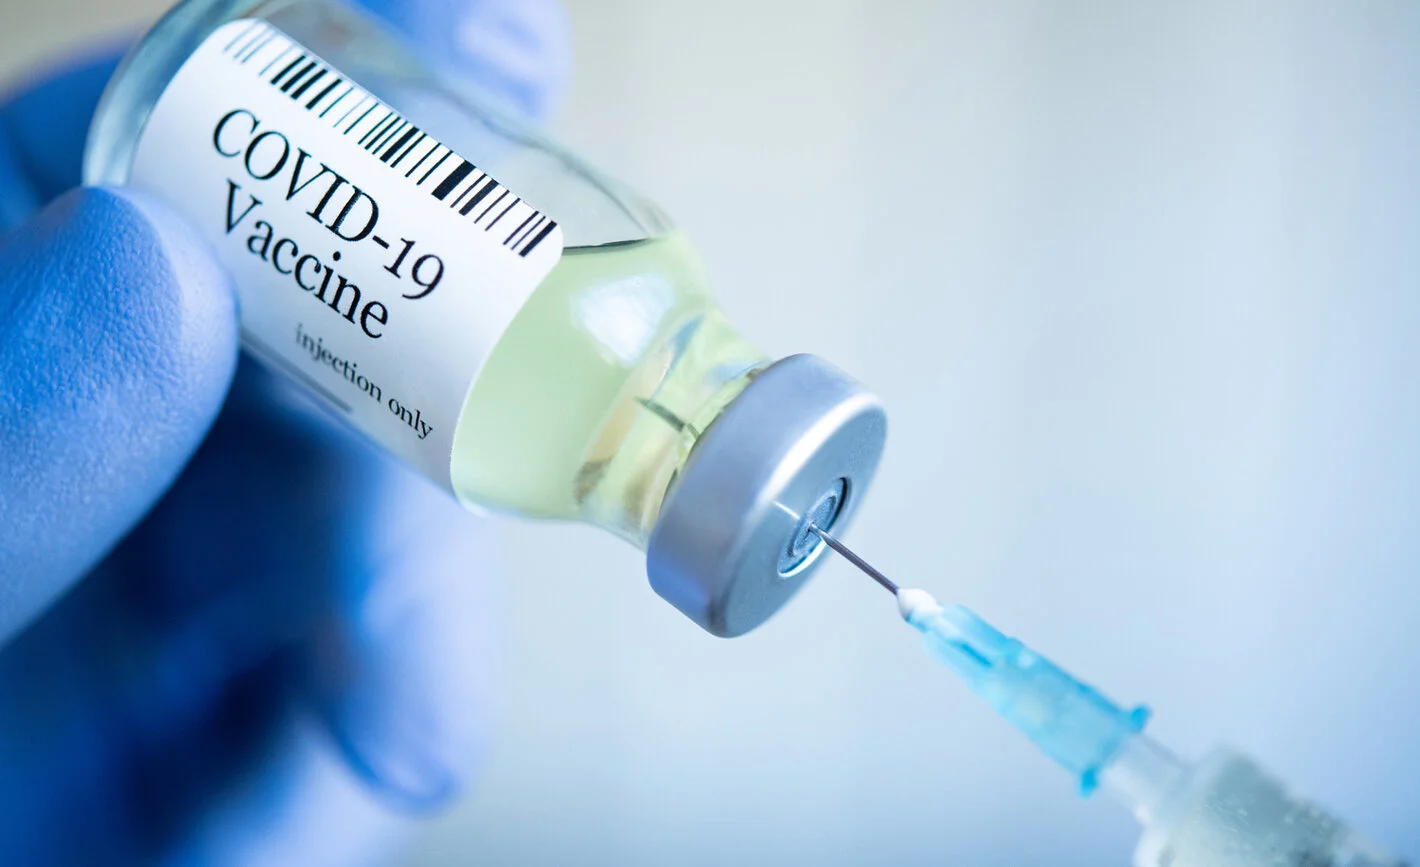


## 1\. Introdução

### 1.1. TLDR `"Too Long; Didn't Read" (em português, "Muito Longo; Não Li").`

* **Dashboard:**
  * Google Looker Studio ([link](https://lookerstudio.google.com/reporting/8c26a003-8245-4a5a-b78a-66788211f139)).
* Processamento:
  * Kaggle Notebook ([link](https://www.kaggle.com/code/lucaszulo/covid-2021)).
* Fontes:
  * Casos pela universidade John Hopkins ([link](https://www.jhu.edu));
  * Vacinação pela universidade de Oxford ([link](https://covid.ourworldindata.org/data/owid-covid-data.csv)).

### 1.2. **Pandemia Coranavírus 2019**

> A COVID-19 é uma infecção respiratória aguda causada pelo coronavírus SARS-CoV-2, potencialmente grave, de elevada transmissibilidade e de distribuição global. Fonte: Governo brasileiro ([link](https://www.gov.br/saude/pt-br/coronavirus/o-que-e-o-coronavirus)).

A disponibilidade de dados sobre a evolução da pandemia no tempo em uma determinada região geográfica é fundamental para o seu combate! Este projeto busca construir um dashboard de dados para exploração e visualização interativa de dados sobre o avanço de casos e da vacinação do Brasil. O processamento de dados está neste [link](https://) e o dashboard, neste [link.](https://)

### 1.3. **Dados**

Os dados sobre **casos da COVID-19** são compilados pelo centro de ciência de sistemas e engenharia da universidade americana **John Hopkins** ([link](https://www.jhu.edu)). Os dados são atualizados diariamente deste janeiro de 2020 com uma granularidade temporal de dias e geográfica de regiões de países (estados, condados, etc.). O website do projeto pode ser acessado neste [link](https://systems.jhu.edu/research/public-health/ncov/) enquanto os dados, neste [link](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports). Abaixo estão descritos os dados derivados do seu processamento.


- **data:** data de referência;
- **estado:** estado;
- **país:** país;
- **população:** população estimada;
- **infectados:** número acumulado de infectados;
- **infectados_diario:** número diário de infectados;
- **media_movel_infectados_7d:** média móvel de 7 dias do número diário de infectados;
- **taxa_media_movel_infectados_7d_14d:** média móvel de 7 dias dividido pela média móvel de 7 dias de 14 dias atrás;
- **mortos:** número acumulado de mortos;
- **mortos_diario:** número diário de mortos;
- **media_movel_mortos_7d:** média móvel de 7 dias do número diário de mortos;
- **taxa_media_movel_mortos_7d_14d:** média móvel de 7 dias dividido pela média móvel de 7 dias de 14 dias atrás;
- **mês:** mês de referência;
- **ano:** ano de referência.

Os dados sobre **vacinação da COVID-19** são compilados pelo projeto Nosso Mundo em Dados (*Our World in Data* ou OWID) da universidade britânica de **Oxford** ([link](https://www.ox.ac.uk)). Os dados são **atualizados diariamente** deste janeiro de 2020 com uma **granularidade temporal de dias e geográfica de países**. O website do projeto pode ser acessado neste [link](https://ourworldindata.org) enquanto os dados, neste [link](https://covid.ourworldindata.org/data/owid-covid-data.csv). Abaixo estão descritos os dados derivados do seu processamento.


- **data**: data de referência;
- **país**: país;
- **população**: população estimada;
- **total**: total de doses administradas;
- **dose_unica**: pessoas com uma dose;
- **percentual_dose_unica**: porcentagem de pessoas com uma dose;
- **duas_doses**: pessoas com duas doses;
- **percentual_duas_doses**: porcentagem de pessoas com duas doses;
- **tres_doses**: pessoas com três doses;
- **percentual_tres_doses**: porcentagem de pessoas com três doses;
- **mês**: mês de referência;
- **ano**: ano de referência.

## 2. **Análise Exploratória de Dados**

Nesta sessão vamos utilizar os seguintes pacotes Python para processar os dados bruto em um formato adequado para um painel para exploração interativa de dados.

In [ ]:
import math
from typing import Iterator
from datetime import datetime, timedelta

import numpy as np
import pandas as pd

### 2.1. **Casos**


Vamos processar os dados de **casos** da universidade John Hopkins.

#### 2.1.1 **Extração**

O dado está compilado em um arquivo por dia, exemplo para 2021/12/01.

In [ ]:
cases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/01-12-2021.csv', sep=',')

In [ ]:
cases.head(2)

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio
0,NaN,NaN,NaN,Afghanistan,2021-01-13 05:22:15,33.93911,67.709953,53584,2301,44608,6675,Afghanistan,137.647787,4.294192
1,NaN,NaN,NaN,Albania,2021-01-13 05:22:15,41.15330,20.168300,64627,1252,38421,24954,Albania,2245.708527,1.937271


In [ ]:
import pandas as pd

# Filtrando o DataFrame para apenas as linhas onde Country_Region é 'Brazil'
brazil_cases = cases[cases['Country_Region'] == 'Brazil']

# Obtendo os valores únicos de Combined_Key para o Brasil
unique_combined_keys_brazil = brazil_cases['Combined_Key'].unique()

print(unique_combined_keys_brazil)

['Acre, Brazil' 'Alagoas, Brazil' 'Amapa, Brazil' 'Amazonas, Brazil'
 'Bahia, Brazil' 'Ceara, Brazil' 'Distrito Federal, Brazil'
 'Espirito Santo, Brazil' 'Goias, Brazil' 'Maranhao, Brazil'
 'Mato Grosso, Brazil' 'Mato Grosso do Sul, Brazil' 'Minas Gerais, Brazil'
 'Para, Brazil' 'Paraiba, Brazil' 'Parana, Brazil' 'Pernambuco, Brazil'
 'Piaui, Brazil' 'Rio Grande do Norte, Brazil' 'Rio Grande do Sul, Brazil'
 'Rio de Janeiro, Brazil' 'Rondonia, Brazil' 'Roraima, Brazil'
 'Santa Catarina, Brazil' 'Sao Paulo, Brazil' 'Sergipe, Brazil'
 'Tocantins, Brazil']


Portanto, precisaremos iterar dentro de um intervalo de tempo definido para extraí-lo.

In [ ]:
def date_range(start_date: datetime, end_date: datetime) -> Iterator[datetime]:
    """
    Função geradora que produz um iterador com todas as datas entre duas datas fornecidas.

    Args:
        start_date (datetime): A data de início (inclusive).
        end_date (datetime): A data de fim (não inclusive).

    Yields:
        datetime: Uma data dentro do intervalo especificado.
    """

    # Calcula o número de dias entre as datas de início e fim.
    date_range_days: int = (end_date - start_date).days

    # Itera sobre cada dia dentro do intervalo.
    for lag in range(date_range_days):
        # Calcula a próxima data somando o deslocamento `lag` (em dias) à data de início.
        yield start_date + timedelta(lag)

In [ ]:
start_date = datetime(2023,  1,  1)
end_date   = datetime(2023, 12, 31)

De maneira iterativa, vamos selecionar as colunas de interesse e as linhas referentes ao Brasil.

In [ ]:
# Define uma variável para armazenar os casos, inicialmente vazia.
cases = None

# Flag para indicar se o DataFrame `cases` está vazio.
cases_is_empty = True

# Itera sobre um intervalo de datas, possivelmente definidas pelas variáveis `start_date` e `end_date`.
for date in date_range(start_date=start_date, end_date=end_date):

    # Formata a data no formato mês-dia-ano (ex: 06-22-2024).
    date_str = date.strftime('%m-%d-%Y')

    # Constrói a URL para acessar o arquivo CSV com os dados diários de COVID-19 da Johns Hopkins University.
    data_source_url = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{date_str}.csv'

    # Lê o arquivo CSV da URL em um DataFrame do Pandas.
    case = pd.read_csv(data_source_url, sep=',')

    # Remove colunas que não serão utilizadas na análise:
    #   - FIPS
    #   - Admin2
    #   - Last_Update
    #   - Lat
    #   - Long_
    #   - Recovered
    #   - Active
    #   - Combined_Key
    #   - Case_Fatality_Ratio
    case = case.drop(['FIPS', 'Admin2', 'Last_Update', 'Lat', 'Long_', 'Recovered', 'Active', 'Combined_Key', 'Case_Fatality_Ratio'], axis=1)

    # Filtra apenas os dados do Brasil.
    case = case.query('Country_Region == "Brazil" and Combined_Key == "Distrito Federal"').reset_index(drop=True)

    # Adiciona uma nova coluna 'Date' com a data formatada como datetime.
    case['Date'] = pd.to_datetime(date.strftime('%Y-%m-%d'))

    # Se o DataFrame `cases` estiver vazio (primeira iteração):
    if cases_is_empty:
        # Atribui o DataFrame `case` (com os dados do primeiro dia) a `cases`.
        cases = case
        # Define a flag `cases_is_empty` como False, pois `cases` não está mais vazio.
        cases_is_empty = False
    # Se o DataFrame `cases` já tiver dados (iterações seguintes):
    else:
        # Concatena o DataFrame `case` (com os dados do dia atual) ao DataFrame `cases`.
        cases = pd.concat([cases, case], ignore_index=True)


In [ ]:
cases['Date'].unique()

<DatetimeArray>
['2021-01-01 00:00:00', '2021-01-02 00:00:00', '2021-01-03 00:00:00',
 '2021-01-04 00:00:00', '2021-01-05 00:00:00', '2021-01-06 00:00:00',
 '2021-01-07 00:00:00', '2021-01-08 00:00:00', '2021-01-09 00:00:00',
 '2021-01-10 00:00:00',
 ...
 '2021-12-21 00:00:00', '2021-12-22 00:00:00', '2021-12-23 00:00:00',
 '2021-12-24 00:00:00', '2021-12-25 00:00:00', '2021-12-26 00:00:00',
 '2021-12-27 00:00:00', '2021-12-28 00:00:00', '2021-12-29 00:00:00',
 '2021-12-30 00:00:00']
Length: 364, dtype: datetime64[ns]

In [ ]:
cases.query('Province_State == "Sao Paulo"').head()

,Province_State,Country_Region,Confirmed,Deaths,Incident_Rate,Date
24,Sao Paulo,Brazil,1466191,46775,3192.990778,2021-01-01
51,Sao Paulo,Brazil,1467953,46808,3196.827966,2021-01-02
78,Sao Paulo,Brazil,1471422,46845,3204.382565,2021-01-03
105,Sao Paulo,Brazil,1473670,46888,3209.278136,2021-01-04
132,Sao Paulo,Brazil,1486551,47222,3237.329676,2021-01-05


#### 2.1.2 **Wrangling**

Vamos manipular os dados para o dashboard. O foco é em garantir uma boa granularidade e qualidade da base de dados.

In [ ]:
cases.head(2)

,Province_State,Country_Region,Confirmed,Deaths,Incident_Rate,Date
0,Acre,Brazil,41689,796,4726.992352,2021-01-01
1,Alagoas,Brazil,105091,2496,3148.928928,2021-01-01


In [ ]:
cases.shape

(9828, 6)

In [ ]:
cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9828 entries, 0 to 9827
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province_State  9828 non-null   object        
 1   Country_Region  9828 non-null   object        
 2   Confirmed       9828 non-null   int64         
 3   Deaths          9828 non-null   int64         
 4   Incident_Rate   9828 non-null   float64       
 5   Date            9828 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 460.8+ KB


Começamos com o nome das colunas.

In [ ]:
# Renomeia as colunas 'Province_State' e 'Country_Region' para 'state' e 'country', respectivamente.
cases = cases.rename(
    columns={
        'Province_State': 'state',
        'Country_Region': 'country'
    }
)

# Itera sobre cada coluna no DataFrame 'cases'.
for col in cases.columns:
    # Renomeia a coluna atual para sua versão em letras minúsculas.
    cases = cases.rename(columns={col: col.lower()})

Ajustamos o nome dos estados.

In [ ]:
states_map = {
    'Amapa': 'Amapá',
    'Ceara': 'Ceará',
    'Espirito Santo': 'Espírito Santo',
    'Goias': 'Goiás',
    'Para': 'Pará',
    'Paraiba': 'Paraíba',
    'Parana': 'Paraná',
    'Piaui': 'Piauí',
    'Rondonia': 'Rondônia',
    'Sao Paulo': 'São Paulo'
}

cases['state'] = cases['state'].apply(lambda state: states_map.get(state) if state in states_map.keys() else state)

Vamos então computar novas colunas para enriquecer a base de dados.

* Chaves temporais:

In [ ]:
cases['month'] = cases['date'].apply(lambda date: date.strftime('%Y-%m'))
cases['year']  = cases['date'].apply(lambda date: date.strftime('%Y'))

* População estimada do estado:

In [ ]:
cases['population'] = round(100000 * (cases['confirmed'] / cases['incident_rate']))
cases = cases.drop('incident_rate', axis=1)

 - Número, média móvel (7 dias) e estabilidade (14 dias) de casos e mortes por estado:

| 1 | 2 | 3 | 4 | 5 | 6 | <font color='red'>7</font> | <font color='green'>8</font> | 9 | 10 | 11 | 12 | 13 | <font color='blue'>14<font color='red'> | 15 | 16 | 17 | 18 | 19 | 20 | 21 |
| - | - | - | - | - | - | - | - | - | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| <font color='red'>D-6</font> | <font color='red'>D-5</font> | <font color='red'>D-4</font> | <font color='red'>D-3</font> | <font color='red'>D-2</font> | <font color='red'>D-1</font> | <font color='red'>D0</font> | | | | | | | | | | | | | | |
| D-7 | <font color='green'>D-6</font> | <font color='green'>D-5</font> | <font color='green'>D-4</font> | <font color='green'>D-3</font> | <font color='green'>D-2</font> | <font color='green'>D-1</font> | <font color='green'>D0</font> | | | | | | | | | | | | | |
| D-13 | D-12 | D-11 | D-10 | D-9 | D-8 | D-7 | <font color='blue'>D-6</font> | <font color='blue'>D-5</font> | <font color='blue'>D-4</font> | <font color='blue'>D-3</font> | <font color='blue'>D-2</font> | <font color='blue'>D-1</font> | <font color='blue'>D0</font> | | | | | | | |

In [ ]:
# Inicializa variáveis para armazenar o conjunto de dados combinado final
cases_ = None
cases_is_empty = True

# Função para determinar a tendência com base na taxa de mudança
def get_trend(rate: float) -> str:
    """
    Categoriza uma taxa de mudança em 'decrescente', 'crescente' ou 'estável'.

    Args:
        rate: A taxa de mudança.

    Returns:
        A categoria de tendência como uma string.
    """
    if np.isnan(rate):
        return np.NaN
    if rate < 0.75:
        status = 'decrescente'
    elif rate > 1.15:
        status = 'estável'
    else:
        status = 'crescente'
    return status

# Itera sobre os estados únicos no conjunto de dados
for state in cases['state'].drop_duplicates():
    # Filtra os dados para o estado atual
    cases_per_state = cases.query(f'state == "{state}"').reset_index(drop=True)
    cases_per_state = cases_per_state.sort_values(by=['date'])  # Classifica por data

    # Calcula as mudanças diárias e médias móveis para casos confirmados
    cases_per_state['confirmados_1d'] = cases_per_state['confirmed'].diff(periods=1)  # Diferença diária
    cases_per_state['confirmados_media_movel_7d'] = np.ceil(cases_per_state['confirmados_1d'].rolling(window=7).mean())
    cases_per_state['taxa_14d_confirmados_media_movel_7d'] = cases_per_state['confirmados_media_movel_7d'] / cases_per_state['confirmados_media_movel_7d'].shift(periods=14)  # Taxa em 14 dias
    cases_per_state['tendencia_confirmados'] = cases_per_state['taxa_14d_confirmados_media_movel_7d'].apply(get_trend) # Tendência com base na taxa

    # Calcula as mudanças diárias e médias móveis para mortes
    cases_per_state['mortes_1d'] = cases_per_state['deaths'].diff(periods=1)
    cases_per_state['mortes_media_movel_7d'] = np.ceil(cases_per_state['mortes_1d'].rolling(window=7).mean())
    cases_per_state['taxa_14d_mortes_media_movel_7d'] = cases_per_state['mortes_media_movel_7d'] / cases_per_state['mortes_media_movel_7d'].shift(periods=14)
    cases_per_state['tendencia_mortes'] = cases_per_state['taxa_14d_mortes_media_movel_7d'].apply(get_trend)

    # Concatena os dados do estado ao conjunto de dados final
    if cases_is_empty:
        cases_ = cases_per_state
        cases_is_empty = False
    else:
        cases_ = pd.concat([cases_, cases_per_state], ignore_index=True)  # Concatenação eficiente

# Substitui o 'cases' original pelos dados processados e libera memória
cases = cases_
# cases_ = None  # Esta linha já está comentada para preservar o resultado.


In [ ]:
cases.columns

Index(['state', 'country', 'confirmed', 'deaths', 'date', 'month', 'year',
       'population', 'confirmados_1d', 'confirmados_media_movel_7d',
       'taxa_14d_confirmados_media_movel_7d', 'tendencia_confirmados',
       'mortes_1d', 'mortes_media_movel_7d', 'taxa_14d_mortes_media_movel_7d',
       'tendencia_mortes'],
      dtype='object')

Vamos traduzir as colunas para o português

In [ ]:
new_column_names = {
    'state': 'estado',
    'country': 'pais',
    'confirmed': 'confirmados',
    'deaths': 'mortes',
    'date': 'data',
    'month': 'mes',
    'year': 'ano',
    'population': 'populacao',
}

cases = cases.rename(columns=new_column_names)

Garantir o tipo do dado é fundamental para consistência da base de dados. Vamos fazer o type casting das colunas.

In [ ]:
cases['populacao'] = cases['populacao'].astype('Int64')
cases['confirmados_1d'] = cases['confirmados_1d'].astype('Int64')
cases['confirmados_media_movel_7d'] = cases['confirmados_media_movel_7d'].astype('Int64')
cases['mortes_1d'] = cases['mortes_1d'].astype('Int64')
cases['mortes_media_movel_7d'] = cases['mortes_media_movel_7d'].astype('Int64')

Por fim, vamos reorganizar as colunas e conferir o resultado final.


In [ ]:
cases.columns

Index(['estado', 'pais', 'confirmados', 'mortes', 'data', 'mes', 'ano',
       'populacao', 'confirmados_1d', 'confirmados_media_movel_7d',
       'taxa_14d_confirmados_media_movel_7d', 'tendencia_confirmados',
       'mortes_1d', 'mortes_media_movel_7d', 'taxa_14d_mortes_media_movel_7d',
       'tendencia_mortes'],
      dtype='object')

In [ ]:
cases = cases [['data', 'pais', 'estado', 'populacao', 'confirmados', 'confirmados_1d', 'confirmados_media_movel_7d', 'taxa_14d_confirmados_media_movel_7d', 'tendencia_confirmados', 'mortes', 'mortes_1d', 'mortes_media_movel_7d', 'taxa_14d_mortes_media_movel_7d', 'tendencia_mortes', 'mes', 'ano']]

In [ ]:
cases.head(25)

,data,pais,estado,populacao,confirmados,confirmados_1d,confirmados_media_movel_7d,taxa_14d_confirmados_media_movel_7d,tendencia_confirmados,mortes,mortes_1d,mortes_media_movel_7d,taxa_14d_mortes_media_movel_7d,tendencia_mortes,mes,ano
0,2021-01-01,Brazil,Acre,881935,41689,<NA>,<NA>,NaN,NaN,796,<NA>,<NA>,NaN,NaN,2021-01,2021
1,2021-01-02,Brazil,Acre,881935,41941,252,<NA>,NaN,NaN,798,2,<NA>,NaN,NaN,2021-01,2021
2,2021-01-03,Brazil,Acre,881935,42046,105,<NA>,NaN,NaN,802,4,<NA>,NaN,NaN,2021-01,2021
3,2021-01-04,Brazil,Acre,881935,42117,71,<NA>,NaN,NaN,806,4,<NA>,NaN,NaN,2021-01,2021
4,2021-01-05,Brazil,Acre,881935,42170,53,<NA>,NaN,NaN,808,2,<NA>,NaN,NaN,2021-01,2021
5,2021-01-06,Brazil,Acre,881935,42378,208,<NA>,NaN,NaN,814,6,<NA>,NaN,NaN,2021-01,2021
6,2021-01-07,Brazil,Acre,881935,42478,100,<NA>,NaN,NaN,821,7,<NA>,NaN,NaN,2021-01,2021
7,2021-01-08,Brazil,Acre,881935,42814,336,161,NaN,NaN,823,2,4,NaN,NaN,2021-01,2021
8,2021-01-09,Brazil,Acre,881935,42908,94,139,NaN,NaN,823,0,4,NaN,NaN,2021-01,2021
9,2021-01-10,Brazil,Acre,881935,43127,219,155,NaN,NaN,825,2,4,NaN,NaN,2021-01,2021


#### 2.1.3 **Carregamento**

Com os dados manipulados, vamos persisti-lo em disco, fazer o seu download e carrega-lo no **Looker Studio**.

In [ ]:
cases.to_csv('./covid-cases.csv', sep=',', index=False)

### 2.2. **Vacinação**

Vamos processar os dados de **vacinação** da universidade de Oxford.

#### 2.2.1 **Extração**

Os dados estão compilados em um único arquivo.

In [ ]:
vaccines = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv', sep=',', parse_dates=[3], infer_datetime_format=True)

<ipython-input-11-608e6d2dd56d>:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  vaccines = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv', sep=',', parse_dates=[3], infer_datetime_format=True)


In [ ]:
vaccines.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-05,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-06,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-07,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-08,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-09,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN


In [ ]:
vaccines.columns


Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

Vamos selecionar as colunas de interesse e as linhas referentes ao Brasil.

In [ ]:
vaccines = vaccines.query('location == "Brazil"').reset_index(drop=True)
vaccines = vaccines[['location', 'population', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters', 'date']]

In [ ]:
vaccines.head(2)

,location,population,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,date
0,Brazil,215313504.0,NaN,NaN,NaN,NaN,2020-01-05
1,Brazil,215313504.0,NaN,NaN,NaN,NaN,2020-01-06


#### **2.2.2. Wrangling**

Vamos manipular os dados para o dashboard. O foco é em garantir uma boa granularidade e qualidade da base de dados.

In [ ]:
vaccines.head()

,location,population,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,date
0,Brazil,215313504.0,NaN,NaN,NaN,NaN,2020-01-05
1,Brazil,215313504.0,NaN,NaN,NaN,NaN,2020-01-06
2,Brazil,215313504.0,NaN,NaN,NaN,NaN,2020-01-07
3,Brazil,215313504.0,NaN,NaN,NaN,NaN,2020-01-08
4,Brazil,215313504.0,NaN,NaN,NaN,NaN,2020-01-09


In [ ]:
vaccines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1618 entries, 0 to 1617
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   location                 1618 non-null   object        
 1   population               1618 non-null   float64       
 2   total_vaccinations       695 non-null    float64       
 3   people_vaccinated        691 non-null    float64       
 4   people_fully_vaccinated  675 non-null    float64       
 5   total_boosters           455 non-null    float64       
 6   date                     1618 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 88.6+ KB


Vamos começar tratando os dados faltantes, a estratégia será a de preencher os buracos com o valor anterior válido mais próximo.

In [ ]:
vaccines = vaccines.fillna(method='ffill')

Vamos também filtrar a base de dados de acordo com a coluna date para garantir que ambas as bases de dados tratam do mesmo período de tempo.

In [ ]:
vaccines = vaccines[(vaccines['date'] >= '2021-01-01') & (vaccines['date'] <= '2021-12-31')].reset_index(drop=True)

Agora, vamos alterar o nome das colunas.

In [ ]:
vaccines = vaccines.rename(
  columns={
    'location': 'pais',
    'population': 'populacao',
    'total_vaccinations': 'total',
    'people_vaccinated': 'dose_unica',
    'people_fully_vaccinated': 'duas_doses',
    'total_boosters': 'tres_doses',
  }
)

Vamos então computar novas colunas para enriquecer a base de dados.

* Chaves temporais

In [ ]:
vaccines['month'] = vaccines['date'].apply(lambda date: date.strftime('%Y-%m'))
vaccines['year']  = vaccines['date'].apply(lambda date: date.strftime('%Y'))

* Dados relativos:

In [ ]:
vaccines['percentual_dose_unica'] = round(vaccines['dose_unica'] / vaccines['populacao'], 4)
vaccines['percentual_duas_doses'] = round(vaccines['duas_doses'] / vaccines['populacao'], 4)
vaccines['percentual_tres_doses'] = round(vaccines['tres_doses'] / vaccines['populacao'], 4)

Garantir o tipo do dado é fundamental para consistência da base de dados. Vamos fazer o type casting das colunas.

In [ ]:
vaccines['populacao'] = vaccines['populacao'].astype('Int64')
vaccines['total'] = vaccines['total'].astype('Int64')
vaccines['dose_unica'] = vaccines['dose_unica'].astype('Int64')
vaccines['duas_doses'] = vaccines['duas_doses'].astype('Int64')
vaccines['tres_doses'] = vaccines['tres_doses'].astype('Int64')

In [ ]:
vaccines.columns

Index(['pais', 'populacao', 'total', 'dose_unica', 'duas_doses', 'tres_doses',
       'date', 'month', 'year', 'percentual_dose_unica',
       'percentual_duas_doses', 'percentual_tres_doses'],
      dtype='object')

Traduzindo as colunas que continuam em inglês

In [ ]:
novas_colunas = {
    'date': 'data',
    'country': 'pais',
    'month': 'mes',
    'year': 'ano'
}

In [ ]:
vaccines = vaccines.rename(columns=novas_colunas)

Por fim, vamos reorganizar as colunas e conferir o resultado final.

In [ ]:
vaccines = vaccines[ ['data', 'pais', 'populacao', 'total', 'dose_unica', 'percentual_dose_unica', 'duas_doses', 'percentual_duas_doses', 'tres_doses', 'percentual_tres_doses', 'mes', 'ano']]

#### **2.2.3. Carregamento**

In [ ]:
vaccines.to_csv('./covid-vaccines.csv', sep=',', index=False)

## 3\. Exploração Interativa de Dados

### **3.1. KPIs**

O dashboard de dados contem os seguintes indicadores chaves de desempenho (*key performance indicator* ou KPI) consolidados:

1. Casos e mortes nas 24 horas;
1. Média móvel (7 dias) de casos e mortes;
1. Tendência de casos e mortes;
1. Proporção de vacinados com 1ª, 2ª e 3ª doses.

### **3.2. EDA**

O dashboard de dados contem os seguintes gráficos para a análise exploratória de dados (*exploratory data analysis*
ou EDA) interativa:

1. Distribuição do números de casos e mortes ao longo do tempo;
1. Distribuição da média móvel (7 dias) do números de casos e mortes ao longo do tempo;
1. Distribuição geográfica dos casos por estado por dia.